In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, SparsePCA
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from statannotations.Annotator import Annotator

# Plotting params

In [2]:
colors = ['#7570b3', '#1b9e77']
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
e_feature_names = ['Firing Rate',
             'Coefficient of Variation',
             'Waveform PC1',
             'Waveform PC2',
             'Waveform PC3',
             'Waveform PC4',
             'Waveform min',
             'Waveform full width half max',
             'Waveform peak to trough',
             'Interspike interval distribution PC1',
             'Interspike interval distribution PC2',
             'Interspike interval distribution PC3',
             'Interspike interval distribution PC4',
             'Autocorrelogram PC1',
             'Autocorrelogram PC2',
             'Autocorrelogram PC3',
             'Autocorrelogram PC4',
             ]

e_feature_names_short = ['Firing Rate',
             'Coef. Var.',
             'Waveform PC1',
             'Waveform PC2',
             'Waveform PC3',
             'Waveform PC4',
             'Waveform min',
             'Waveform FWHM',
             'Waveform PT',
             'ISI PC1',
             'ISI PC2',
             'ISI PC3',
             'ISI PC4',
             'ACG PC1',
             'ACG PC2',
             'ACG PC3',
             'ACG PC4',
             ]

# Load data

In [4]:
from analysis_utils import load_json_restore_arrays
df = load_json_restore_arrays('../data/data_electrophysiology.json')

In [5]:
# HI LISA, I ADDED THESE, IOANNIS

# Calculate the mean spontaneous firing rate
df['firing_rate'] = df.spikes.apply(lambda x: len(x)) / df.recording_dur
df['firing_rate'] = df['firing_rate'].round(2).astype(float)

# Caclulate the spike half-width duration
from analysis_utils import get_waveshape_FWHM
df['waveshape_FWHM'] = df.apply(lambda row: get_waveshape_FWHM(row['waveshape'], row['waveshape_tv']), axis=1)

# Calculate the peak-to-trough duration
from analysis_utils import get_waveshape_peak_to_trough
df['waveshape_peakToTrough'] = df.apply(lambda row: get_waveshape_peak_to_trough(row['waveshape'], row['waveshape_tv']), axis=1)

In [6]:
df_pos = df[df['TH_label'] == 'pos']
df_neg = df[df['TH_label'] == 'neg']

df['TH'] = (df['TH_label'].values == 'pos')*1

In [7]:
features_e = ['firing_rate',
                'cv2',
                'waveshape_pc0_stdz',
                'waveshape_pc1_stdz',
                'waveshape_pc2_stdz',
                'waveshape_pc3_stdz',
                'waveshape_min_stdz',
                'waveshape_FWHM',
                'waveshape_peakToTrough',
                'ISI_pc0_stdz',
                'ISI_pc1_stdz',
                'ISI_pc2_stdz',
                'ISI_pc3_stdz',
                'ACG_wide_pc0_stdz',
                'ACG_wide_pc1_stdz',
                'ACG_wide_pc2_stdz',
                'ACG_wide_pc3_stdz',
             ]


# Extract temporal features using sparse PCA

KeyError: ['ISI']

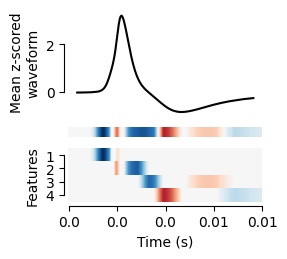

In [8]:
def process_feature(df, feature_name, figsize, sparsity, num_pcs, cmap):
    df_pca = df.dropna(subset=[feature_name])
    if df_pca.shape[0] != df.shape[0]:
        print(f'Neurons had to be removed due to NaN values: {df.shape[0] - df_pca.shape[0]}')
    X = np.vstack(df_pca[feature_name].to_list())
    # Standardize per neuron
    X = np.array([(x - np.mean(x)) / np.std(x) if x.sum() else np.zeros_like(x) for x in X])
    
    # Sparse PCA
    pca_model = SparsePCA(n_components=num_pcs, alpha=sparsity).fit(X)
    X_pca = pca_model.transform(X)

    # Sort components in temporal order
    tv = df.iloc[0][f'{feature_name}_tv']
    pcs_time_max = tv[tv >= 0][np.argmax(np.abs(pca_model.components_[:, tv >= 0]), axis=1)]
    pcs_order = np.argsort(pcs_time_max)
    pca_components_sorted = pca_model.components_[pcs_order]
    X_pca_sorted = X_pca[:, pcs_order]

    plot_pca_components(tv, X, pca_components_sorted, figsize, cmap, num_pcs=num_pcs)

def plot_pca_components(tv, X, pca_components, figsize, cmap, num_pcs):
    fig, axs = plt.subplots(3, 1, figsize=figsize, gridspec_kw={"height_ratios": [1, .1, .5]})
    vminmax = np.max(np.abs([pca_components.min(), pca_components.max()]))
    axs[0].plot(tv, np.mean(X, axis=0), 'k')
    axs[0].set_ylim([-1, 3.5])
    axs[0].set_xticks([])
    axs[0].set_ylabel('Mean z-scored\nwaveform')
    axs[1].imshow(pca_components.sum(axis=0)[np.newaxis, :], aspect='auto', cmap=cmap, vmin=-vminmax, vmax=vminmax)
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    im = axs[2].imshow(pca_components, interpolation='none', aspect='auto', cmap=cmap, vmin=-vminmax, vmax=vminmax)
    axs[2].set_xticks(np.linspace(0, tv.shape[0], 5))
    axs[2].set_xticklabels(np.round(np.linspace(tv[0], tv[-1], 5), 2))
    axs[2].set_yticks(np.arange(num_pcs))
    axs[2].set_yticklabels(np.arange(1, num_pcs + 1))
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Features')
    sns.despine(offset=3, trim=True)
    axs[0].spines['bottom'].set_visible(False)
    axs[1].spines['bottom'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    fig.patch.set_facecolor('white')

# Example usage
features_to_process = ['waveshape', 'ISI', 'ACG_wide']
for feature_name in features_to_process:
    process_feature(df, feature_name, figsize=(2.5, 2.5), sparsity=1, num_pcs=4, cmap='RdBu_r')

# PCA analysis

In [ ]:
# Get data
df_e = df[features_e + ['TH']] if 'TH' not in features_e else df[features_e]
y = df_e['TH'].values

# Boolean indexing for positive and negative instances
idx_pos = y > 0.5
idx_neg = y < 0.5

# Standardize data (with handling NaNs in one step)
X_standardized = StandardScaler().fit_transform(df_e[features_e].to_numpy())
X_standardized = np.nan_to_num(X_standardized, nan=0)

# PCA
num_pcs = 4
pca = PCA(n_components=num_pcs)
X_pca = pca.fit_transform(X_standardized)  # Combining fit and transform in a single step

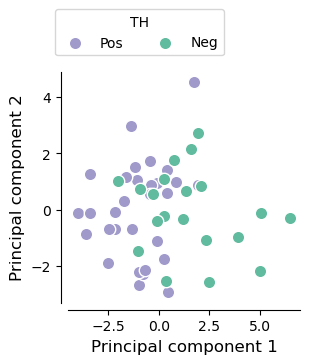

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(X_pca[idx_pos,0], X_pca[idx_pos,1], facecolors='none', facecolor='#9f9acaff', edgecolor='white', label='Pos', s=80, zorder=1)
ax.scatter(X_pca[idx_neg,0], X_pca[idx_neg,1], facecolors='none', facecolor='#60bb9fff', edgecolor='white', label='Neg', s=80, zorder=1)
ax.legend(ncol=2, frameon=True, bbox_to_anchor=(.7, 1.3), title='TH')
ax.set_xlabel('Principal component 1', fontsize=12)
ax.set_ylabel('Principal component 2', fontsize=12)

sns.despine(offset=5)

fig.patch.set_facecolor('white')

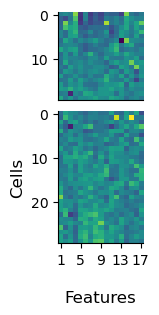

In [ ]:
num_cells = X_standardized.shape[0]
proportion_cluster = []
cluster_sizes = []
for i in range(2):
    cluster_size = np.where(np.array(y)==i)[0].shape[0]
    cluster_sizes.append(cluster_size)
    proportion_cluster.append(cluster_size/num_cells)

X_pos_standardized = np.squeeze(X_standardized[idx_pos,:])
X_pos_pc = np.squeeze(X_pca[idx_pos,0])
X_pos_pc_idx_sort = np.argsort(X_pos_pc)
X_pos_plot = X_pos_standardized[X_pos_pc_idx_sort[::-1]]

X_neg_standardized = np.squeeze(X_standardized[idx_neg,:])
X_neg_pc = np.squeeze(X_pca[idx_neg,0])
X_neg_pc_idx_sort = np.argsort(X_neg_pc)
X_neg_plot = X_neg_standardized[X_neg_pc_idx_sort[::-1]]

fig, axs = plt.subplots(2,1, figsize=(1.1,3), gridspec_kw={'height_ratios': proportion_cluster, 'hspace':0.1})
axs[0].imshow(X_neg_plot, cmap='viridis', vmin=X_standardized.min(), vmax=X_standardized.max(), aspect='auto')
axs[0].set_xticks([])
axs[0].set_xticklabels([])

axs[1].imshow(X_pos_plot, cmap='viridis', vmin=X_standardized.min(), vmax=X_standardized.max(), aspect='auto')
axs[1].set_xticks(np.arange(0,X_standardized.shape[1], 4))
axs[1].set_xticklabels(np.arange(0,X_standardized.shape[1], 4)+1)
axs[1].set_ylabel('Cells', fontsize=12)
axs[1].set_xlabel('\nFeatures', fontsize=12)

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.patch.set_facecolor('white')

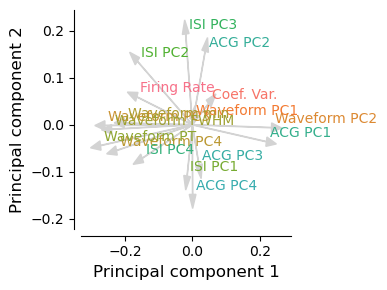

In [ ]:
colormap = 'husl'
num_features = len(e_feature_names_short)
sns_cmap = sns.color_palette(colormap, n_colors=30).as_hex()
cmap = matplotlib.colors.ListedColormap(sns_cmap)

# Principal components correlation coefficients
loadings = pca.components_
# Get the loadings of x and y axes
xs = (loadings[0,:]*pca.explained_variance_[0])/np.sqrt(X_pca.shape[0]-1)
ys = (loadings[1,:]*pca.explained_variance_[1])/np.sqrt(X_pca.shape[0]-1)

fig, ax = plt.subplots(1,1,figsize=(3.9,3))
for i, feat_e_name in enumerate(e_feature_names_short):
    ax.text(x=xs[i]+.01, y=ys[i]+.01, s=feat_e_name, color=cmap.colors[i])
    ax.plot([-.2,.2], [-.2,.2], color='none')
    ax.arrow(x=0, y=0, # coordinates of arrow base
            dx=xs[i], # length of the arrow along x
            dy=ys[i], # length of the arrow along y
            color='lightgray', 
            head_width=.02,
            )
ax.set_xlabel('Principal component 1', fontsize=12)
ax.set_ylabel('Principal component 2', fontsize=12)

sns.despine(offset=5)

fig.tight_layout()
fig.patch.set_facecolor('white')

# Classifier

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
y = df['TH'].values
X = df[features_e].values
#X = np.nan_to_num(X, nan=0)

# Log. regr. grid search
regs = np.linspace(1e-4, 30e0, 100)
lr_pipeline = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', solver='liblinear', random_state=0, max_iter=10000))
lr_gridsearch = GridSearchCV(lr_pipeline, {'logisticregression__C': regs}, cv=5, verbose=0, scoring='accuracy').fit(X, y)

print('Mean max. accuracy over cross validations: {:.4f}'.format(max(lr_gridsearch.cv_results_['mean_test_score'])))

reg = lr_gridsearch.best_params_['logisticregression__C']

print(f'for regularization: {reg}')

Mean max. accuracy over cross validations: 0.7600
for regularization: 2.121305050505051


In [ ]:
weights = lr_gridsearch.best_estimator_.named_steps['logisticregression'].coef_.squeeze()

findfont: Font family ['Times New'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New'] not found. Falling back to DejaVu Sans.


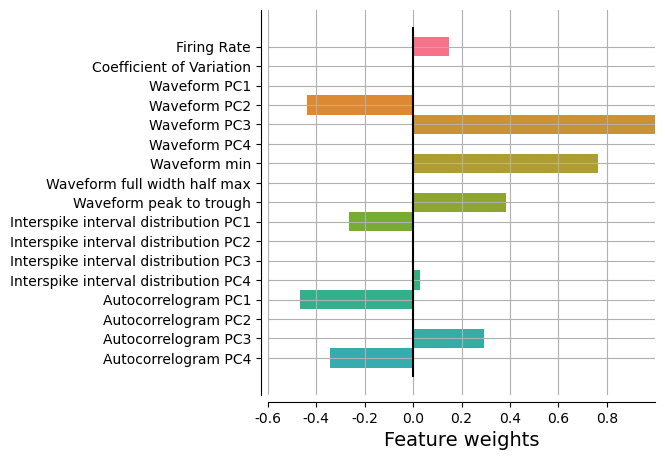

In [ ]:
plt.rcParams["font.family"] = "Times New"

xlim = [-.6, 1]
xtick_gridw = .2

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.barh(np.arange(weights.shape[0]), weights, color=sns_cmap, height=1)
ax.vlines(x=0, ymin=-1, ymax=len(features_e), color='k')
ax.set_xticks(np.arange(xlim[0],xlim[1],xtick_gridw))
ax.set_xticklabels(np.round(np.arange(xlim[0],xlim[1],xtick_gridw),1), fontsize=12)
ax.set_xlim(xlim)
ax.set_xlabel('Feature weights', fontsize=14)
ax.invert_yaxis()
ax.set_yticks(np.arange(len(features_e)))
ax.set_yticklabels(e_feature_names)
plt.grid()

sns.despine(offset=5)

fig.patch.set_facecolor('white')

### Confusion matrix

In [ ]:
lr_gs_fit = lr_gridsearch.fit(X, y)

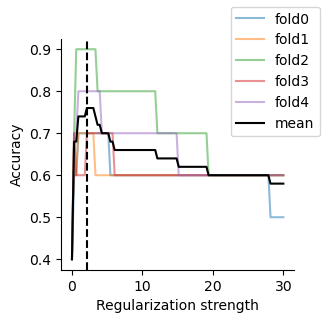

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(3,3))

for i in range(5):
    ax.plot(regs, lr_gs_fit.cv_results_[f'split{i}_test_score'], alpha=.5, label=f'fold{i}')
    
ax.plot(regs, lr_gs_fit.cv_results_['mean_test_score'], 'k', label='mean')
ax.axvline(reg, color='k', linestyle='--')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Regularization strength')
fig.legend()
sns.despine()

In [ ]:
# find the best regularization 
print('Mean max. accuracy over cross validations: {:.4f}'.format(max(lr_gridsearch.cv_results_['mean_test_score'])))
reg = lr_gridsearch.best_params_['logisticregression__C']
print(f'for regularization: {reg}')

Mean max. accuracy over cross validations: 0.7600
for regularization: 2.121305050505051


In [ ]:
yhat = cross_val_predict(lr_gridsearch.best_estimator_, X, y, cv=5)
conf_mat = confusion_matrix(y, yhat)

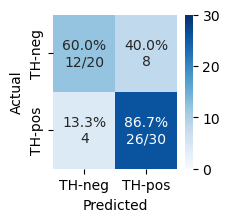

In [ ]:
cm = conf_mat
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)
cm = pd.DataFrame(cm, 
                 )
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

fig, ax = plt.subplots(figsize=(2,2))
sns.heatmap(cm, annot=annot, fmt='', ax=ax, vmin=0, vmax=30, cmap='Blues')
ax.set_xticklabels(['TH-neg', 'TH-pos'])
ax.set_yticklabels(['TH-neg', 'TH-pos'])

fig.patch.set_facecolor('white')